In [6]:
import numpy as np
import torch
import scipy.signal as sp
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchaudio.functional import convolve
from torchaudio.transforms import InverseSpectrogram, Spectrogram, InverseSpectrogram
from IPython.display import Audio
from fb_utils import fir_tightener3000, fir_tightener4000, frame_bounds_lp, random_filterbank

In [7]:
with open('audfreqz_red4.npy', 'rb') as f:
    gf = np.load(f)

In [8]:
import librosa
speech_full = librosa.load('test.wav')
speech_full = librosa.resample(speech_full[0],orig_sr=22050,target_sr=16000)
# speech = speech_full[1500:1500+len].reshape(1,-1)
len = 80000
speech = speech_full[:len].reshape(1,-1)

#speech = np.append(speech, np.zeros((1,len*4)),axis=1)

x = torch.randn(2,1,len)
x[0,0,:] = torch.tensor(speech / np.linalg.norm(speech), dtype=torch.float32)
x.shape

torch.Size([2, 1, 80000])

In [9]:
def gauss(L, sigma):
    g = np.exp(-np.pi * np.arange(-L//2,L//2)**2 / (sigma/2)**2)
    g_c = g
    return g_c.reshape(1,-1)

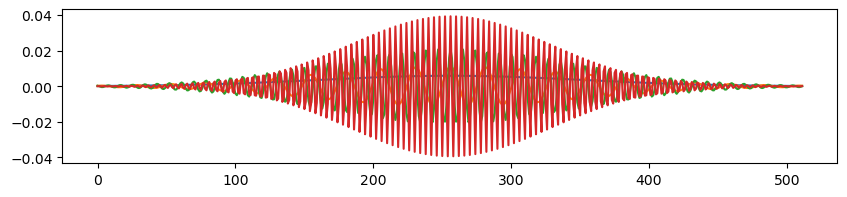

In [10]:
# Audlet style filterbank
supp = 512
supper = gauss(supp, supp-12)
g = np.fft.ifft(gf, axis=0)
g = np.roll(g, supp//2, axis=0)
g_re = np.real(g[:supp]).T * supper
g_im = np.imag(g[:supp]).T * supper
g_c = g_re + 1j*g_im
g_re_tensor = torch.tensor(g_re, dtype=torch.float32).unsqueeze(1)
g_im_tensor = torch.tensor(g_im, dtype=torch.float32).unsqueeze(1)
# g_c_tensor = torch.tensor(g_c, dtype=torch.complex64).unsqueeze(1)

num = np.arange(1,256,64)
plt.figure(figsize=(10,2))
plt.plot(g_re[num,:].T)
# plt.plot(g_im[num,:].T)
plt.show()

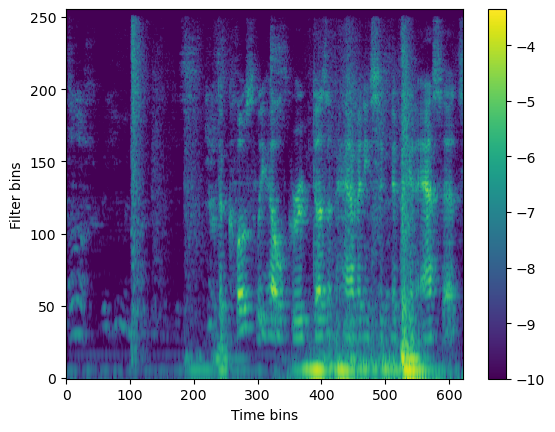

In [11]:
stride = 128

x_enc_re = F.conv1d(x, g_re_tensor, stride=stride, padding=0)
x_enc_im = F.conv1d(x, g_im_tensor, stride=stride, padding=0)
x_enc_mag = x_enc_re**2 + x_enc_im**2

plt.imshow(np.log10(x_enc_mag.numpy()[0,:,:]), vmin=-10, aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Time bins')
plt.ylabel('Filter bins')

x_tilde_re = F.conv_transpose1d(x_enc_re, g_re_tensor, stride=stride, padding=0).squeeze(0)
x_tilde_im = F.conv_transpose1d(x_enc_im, g_im_tensor, stride=stride, padding=0).squeeze(0)
x_tilde = x_tilde_re + x_tilde_im

In [473]:
Audio(data=x_tilde[0,:,:80000].numpy(), rate=16000)

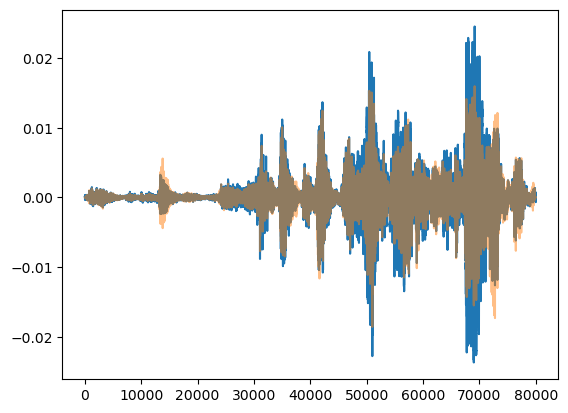

In [472]:
plt.plot(x[0,:,:].T)
plt.plot(x_tilde[0,:,:].T*8, alpha = 0.5)

In [311]:
x_tilde.shape

torch.Size([2, 1, 80000])

In [349]:
Audio(data=x[0,:,:80000].numpy(), rate=16000)

In [14]:
g_supp = g_re + 1j*g_im

g_re_tight = fir_tightener3000(g_re, supp)
g_im_tight = fir_tightener3000(g_im, supp)
g_tight = g_re_tight + 1j*g_im_tight
g_re_tight_tensor = torch.tensor(g_re_tight, dtype=torch.float32).unsqueeze(1)
g_im_tight_tensor = torch.tensor(g_im_tight, dtype=torch.float32).unsqueeze(1)

In [15]:
g_supp.shape

(256, 512)

In [463]:
# with open('aud_512_re.npy', 'wb') as f:
#     np.save(f, g_re_tight)

# with open('aud_512_im.npy', 'wb') as f:
#     np.save(f, g_im_tight)

with open('auditory_filters_256_short.npy', 'wb') as f:
    np.save(f, g_supp)

In [16]:
num_filters = g_re_tight_tensor.shape[0]

In [17]:
# random filterbank
supp_ran = 31
W_random = random_filterbank(supp_ran, num_filters, supp_ran, norm=False, tight=False, to_torch=False, support_only=True)
W_random = fir_tightener3000(W_random, supp_ran)
W_random_tensor = torch.tensor(W_random, dtype=torch.float32).unsqueeze(1)

In [18]:
model = torch.load('trained_models/aud_bias.pth',map_location=torch.device('cpu'))
W_random_trained = model['model_state_dict']['filterbank.encoder.weight'][:256,:,:64]

In [19]:
model = torch.load('trained_models/aud_init_tight.pth',map_location=torch.device('cpu'))
W_random_only_trained = model['model_state_dict']['filterbank.encoder.weight'][:256,:,:64]

In [20]:
stride = 32
stride_ran = 1

x_enc_re = F.conv1d(x, g_re_tight_tensor, stride=stride)
x_enc_im = F.conv1d(x, g_im_tight_tensor, stride=stride)

x_enc_re_both = F.conv1d(x_enc_re, W_random_tensor, stride=stride_ran, groups=num_filters, padding='same').squeeze(0)
x_enc_im_both = F.conv1d(x_enc_im, W_random_tensor, stride=stride_ran, groups=num_filters, padding='same').squeeze(0)

x_enc_re_trained = F.conv1d(x_enc_re, W_random_trained, stride=stride_ran, groups=num_filters, padding='same').squeeze(0)
x_enc_im_trained = F.conv1d(x_enc_im, W_random_trained, stride=stride_ran, groups=num_filters, padding='same').squeeze(0)

x_enc_ran_trained = F.conv1d(x, W_random_only_trained, stride=32).squeeze(0)

x_enc_ran = F.conv1d(x, W_random_tensor, stride=32).squeeze(0)

x_tilde_re = F.conv_transpose1d(x_enc_re, g_re_tight_tensor, stride=stride).squeeze(0)
x_tilde_im = F.conv_transpose1d(x_enc_im, g_im_tight_tensor, stride=stride).squeeze(0)

In [21]:
# magnitude response
x_enc_mag = x_enc_re**2 + x_enc_im**2

x_enc_mag_both = x_enc_re_both**2 + x_enc_im_both**2

x_enc_mag_trained = x_enc_re_trained**2 + x_enc_im_trained**2

x_enc_mag_ran = torch.abs(x_enc_ran)**2

x_enc_mag_ran_trained = torch.abs(x_enc_ran_trained)**2

# reconstruction
x_tilde = (x_tilde_re + x_tilde_im)/2*stride

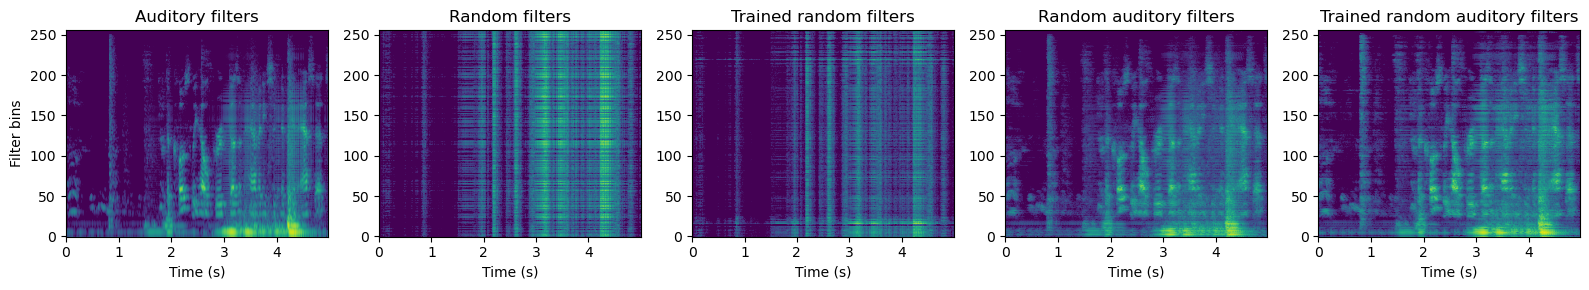

In [22]:
# imshow the enc
plt.figure(figsize=(16, 3))
plt.subplot(1, 5, 1)
plt.imshow(np.log10(x_enc_mag.numpy()[0,:,:]), vmin=-10, aspect='auto', origin='lower')
plt.xticks([0,500,1000,1500,2000], [0,1,2,3,4])
plt.xlabel('Time (s)')
plt.ylabel('Filter bins')
plt.title('Auditory filters')

plt.subplot(1, 5, 2)
plt.imshow(np.log10(x_enc_mag_ran.numpy()[0,:,:]), vmin=-10, aspect='auto', origin='lower')
plt.xticks([0,500,1000,1500,2000], [0,1,2,3,4])
plt.xlabel('Time (s)')
plt.title('Random filters')

plt.subplot(1, 5, 3)
plt.imshow(np.log10(x_enc_mag_ran_trained.numpy()[0,:,:]), vmin=-9, aspect='auto', origin='lower')
plt.xticks([0,500,1000,1500,2000], [0,1,2,3,4])
plt.xlabel('Time (s)')
plt.title('Trained random filters')

plt.subplot(1, 5, 4)
plt.imshow(np.log10(x_enc_mag_both.numpy()[0,:,:]), vmin=-13, aspect='auto', origin='lower')
plt.xticks([0,500,1000,1500,2000], [0,1,2,3,4])
plt.xlabel('Time (s)')
plt.title('Random auditory filters')

plt.subplot(1, 5, 5)
plt.imshow(np.log10(x_enc_mag_trained.numpy()[0,:,:]), vmin=-11, aspect='auto', origin='lower')
plt.xticks([0,500,1000,1500,2000], [0,1,2,3,4])
plt.xlabel('Time (s)')
plt.title('Trained random auditory filters')

plt.tight_layout()
plt.savefig('responses_all.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

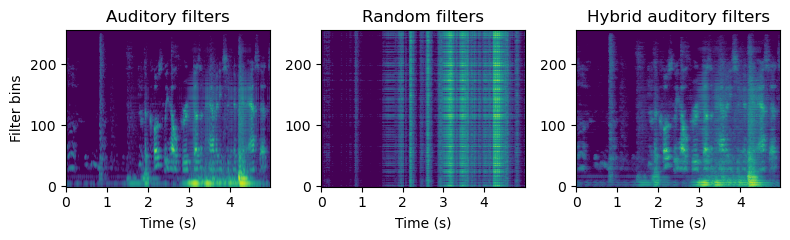

In [31]:
# imshow the enc
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(np.log10(x_enc_mag.numpy()[0,:,:]), vmin=-10, aspect='auto', origin='lower')
plt.xticks([0,500,1000,1500,2000], [0,1,2,3,4])
plt.xlabel('Time (s)')
plt.ylabel('Filter bins')
plt.title('Auditory filters')

plt.subplot(1, 3, 2)
plt.imshow(np.log10(x_enc_mag_ran.numpy()[0,:,:]), vmin=-10, aspect='auto', origin='lower')
plt.xticks([0,500,1000,1500,2000], [0,1,2,3,4])
plt.xlabel('Time (s)')
plt.title('Random filters')

plt.subplot(1, 3, 3)
plt.imshow(np.log10(x_enc_mag_both.numpy()[0,:,:]), vmin=-13, aspect='auto', origin='lower')
plt.xticks([0,500,1000,1500,2000], [0,1,2,3,4])
plt.xlabel('Time (s)')
plt.title('Hybrid auditory filters')

plt.tight_layout()
plt.savefig('responses.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

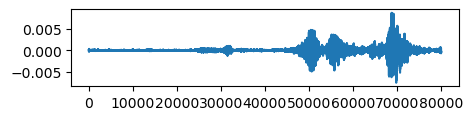

In [325]:
plt.figure(figsize=(5, 1))
plt.plot(x[0,:,:].T-x_tilde[0,:,:].T)

In [326]:
Audio(data=x_tilde[0,:,:80000].numpy(), rate=16000)

In [218]:
from scipy.interpolate import interp1d

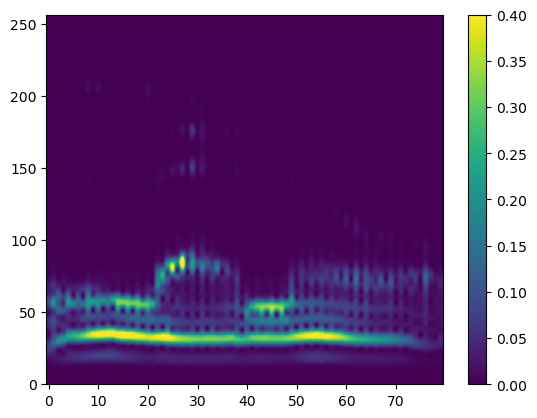

In [225]:
coef_both = np.zeros_like(x_enc_mag_both.numpy()[0,:,:])

M = coef_both.shape[0]
Nc = coef_both.shape[1]
f = interp1d(np.linspace(0, 1, Nc), x_enc_mag_both.numpy()[0,:,:], kind='nearest', axis=1)
C_both = f(np.linspace(0, 1, 36))

x_red = x_enc_mag.numpy()[0,:,:]

coef = np.zeros_like(x_red)

M = coef.shape[0]
Nc = coef.shape[1]
f = interp1d(np.linspace(0, 1, Nc), x_red, kind='linear', axis=1)
C = f(np.linspace(0, 1, 80))

plt.imshow(C, aspect='auto', origin='lower', vmin=0, vmax=0.4)
plt.colorbar()

In [45]:
Audio(data=x_tilde[0,:,:].numpy(), rate=16000)

In [54]:
torch.norm(x_enc_stft[0,0,:,:]), torch.norm(x_enc_mag[0,:,:]), torch.norm(x_enc_mag_both[0,:,:])

(tensor(13.6876), tensor(23.5997), tensor(0.0921))

In [51]:
x_enc_stft[0,0,:,:].shape, x_enc_mag[0,:,:].shape, x_enc_mag_both[0,:,:].shape

(torch.Size([257, 40]), torch.Size([257, 562]), torch.Size([257, 547]))